In [27]:
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from collections import Counter
import datetime
import pandas as pd
import numpy as np
import umap
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import sparse
import matrix
import logger

In [48]:
#LatentDirichletAllocation
def get_terms(topic_number, corpus, component):
    component_for_topic = component[topic_number, :][0]
    corpus_weight_for_topic = zip(corpus, component_for_topic)
    return np.array(sorted(corpus_weight_for_topic, key=lambda x: x[1], reverse=True)[:30])[:, 0]


def get_top_terms_for_even_documents(svd, component, corpus):
    significant_topic_for_each_row = np.argmax(svd, axis=1).reshape((svd.shape[0], 1))
    return np.apply_along_axis(get_terms, 1, significant_topic_for_each_row, corpus, component)    

topic_count = 25

logger.log('start')
matrix_documents, terms = matrix.read_matrix()
origignal_matrix = matrix_documents.toarray()
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=topic_count, random_state=0, max_iter=30, doc_topic_prior=0.05, topic_word_prior=0.05, evaluate_every=1)
topics = lda.fit_transform(origignal_matrix)
components = lda.components_


top_terms = get_top_terms_for_even_documents(topics, components, terms)
embedding = TSNE(n_components=2,random_state=5).fit_transform(topics)

logger.log('end')

2020-05-06 12:37:43 - start
2020-05-06 13:06:55 - end


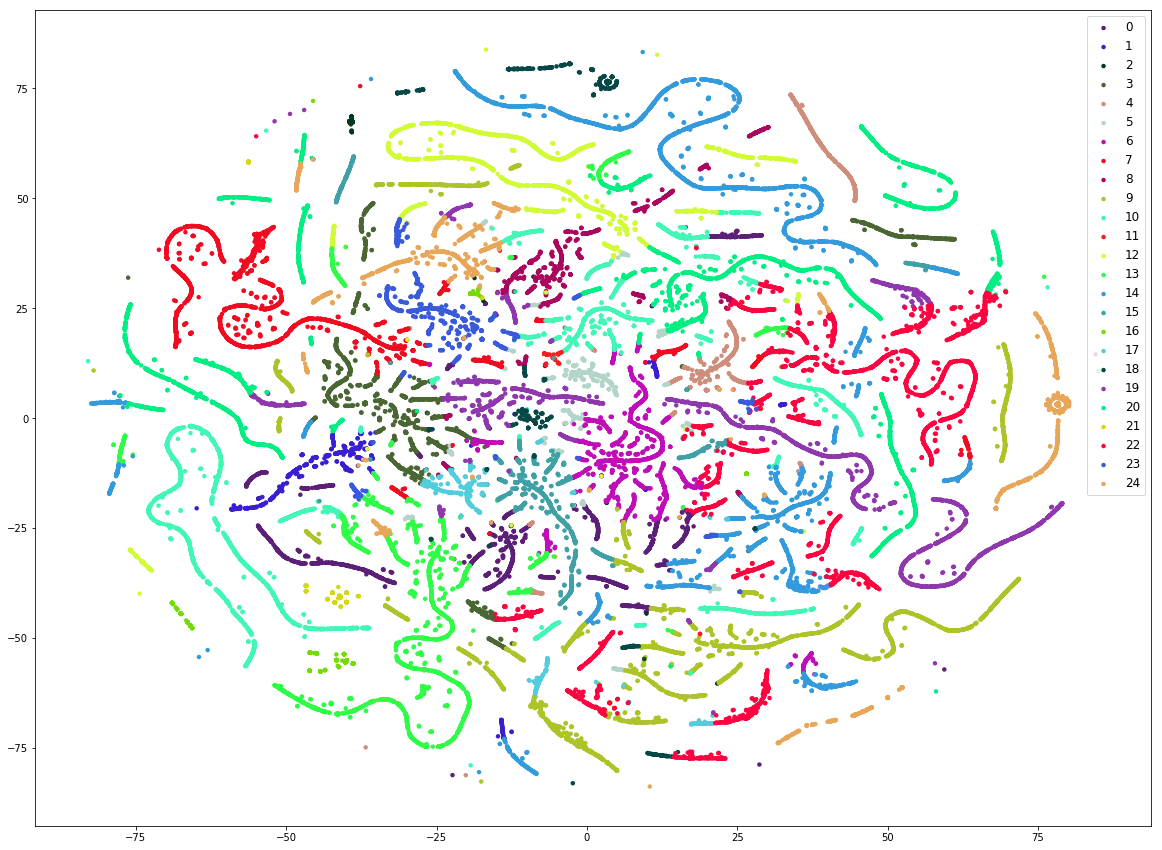

In [51]:
clusters_by_topics = np.argmax(topics, axis=1).reshape((topics.shape[0], 1))
df = pd.DataFrame(clusters_by_topics, columns=['cluster_n'])
df['Id'] = np.arange(len(df))
df['x'] = embedding[:, 0]
df['y'] = embedding[:, 1]

plt.figure(figsize=(20, 15))
group_by_cluster = df.groupby('cluster_n')
for name, group in group_by_cluster:        
    c = np.array([np.random.rand(3,)]* len(group['Id']))
    plt.scatter(group['x'], group['y'],
                s=20,
                c=c,
                edgecolor='none',
               label=name)
    
plt.legend(fontsize=12)

In [52]:
def print_topics(count_related_words, components, terms):
    for i, comp in enumerate(components):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:count_related_words]
        topic = "Topic " + str(i) + ": "
        for sorted_term in sorted_terms:
            topic = topic + sorted_term[0] + ' '
        print()
        print(topic)

print_topics(70, components, terms )


Topic 0: администрирование linux система мониторинг сервер инфраструктура настройка ос bash сервис python поддержка ansible ci база развёртывание docker субд виртуализация решение postgresql zabbix автоматизация devops сетевой скрипт язык cd oracle резервный технология приложение windows nginx производительность технический копирование системный администратор управление бд vmware unix сопровождение уровень принцип kubernetes обеспечение платформа навык процесс команда mysql плюс задача написание centos проблема скриптовый серверный apache облачный инженер sql эксплуатация jenkins развитие внедрение компания проект 

Topic 1: 1с предприятие учёт erp внедрение проект платформа автоматизация конфигурация компания бухгалтерский программист бизнес задача система специалист зарплата управление фирма сертификат консультант программный решение заказчик бухгалтерия типовой область производственный сопровождение участие технический корп налоговый пользователь задание управленческий продукт зуп 